In [1]:
import h5py
import numpy as np
import umap
from umap.umap_ import nearest_neighbors
import pylab as pl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

In [2]:
f = h5py.File('../data/TNG100-1/Subhalos_Features/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_084.hdf5','r')
f.keys()

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>

In [3]:
stellar_phot_ids = f['subhaloIDs'][:]
stellar_phot_ids

array([      0,       1,       2, ..., 4527124, 4527125, 4527126],
      dtype=int32)

In [4]:
f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc']

<HDF5 dataset "Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc": shape (4527127, 8, 12), type "<f4">

In [5]:
Mu = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:,0,0]
Mg = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:,1,0]
Mr = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:,2,0]
Mi = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:,3,0]
Mz = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:,4,0]
f.close()

In [6]:
stellar_phot_df = pd.DataFrame(np.c_[stellar_phot_ids, Mu, Mg, Mr, Mi, Mz], columns=['ID','Mu','Mg','Mr','Mi','Mz'])
stellar_phot_df = stellar_phot_df.dropna()
stellar_phot_df

,ID,Mu,Mg,Mr,Mi,Mz
0,0.0,-19.918682,-21.427780,-22.115793,-22.478964,-22.796307
1,1.0,-20.797749,-22.592024,-23.387402,-23.785805,-24.137964
2,2.0,-21.605118,-22.969065,-23.532661,-23.849113,-24.145828
3,3.0,-20.388245,-21.703148,-22.265253,-22.584154,-22.873615
4,4.0,-19.744356,-21.458693,-22.222290,-22.607536,-22.939856
...,...,...,...,...,...,...
4490245,4490245.0,-7.376702,-8.596647,-9.148641,-9.423900,-9.556947
4493007,4493007.0,-7.929919,-9.245331,-9.829266,-10.115916,-10.286570
4514472,4514472.0,-8.059139,-9.316813,-9.870451,-10.172428,-10.342423
4520126,4520126.0,-7.635355,-9.033590,-9.685241,-10.004305,-10.200866


In [7]:
stellar_phot_df = stellar_phot_df[stellar_phot_df['Mr'] > -21]
stellar_phot_df = stellar_phot_df[stellar_phot_df['Mr'] < -19]

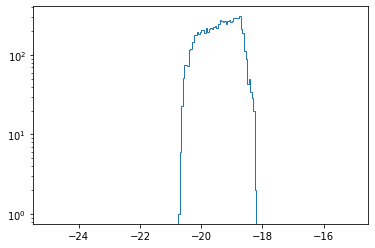

In [8]:
_ = pl.hist(stellar_phot_df['Mg'], bins=np.arange(-25,-15, 0.05), histtype='step')
pl.yscale('log')

In [9]:
100*np.mean(stellar_phot_df['Mg']<-16)

100.0

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


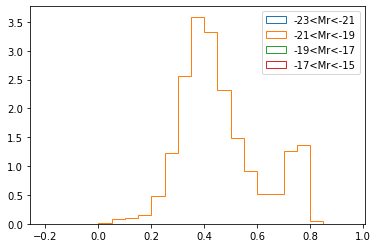

In [10]:
cuts = [-23,-21,-19,-17,-15]

for i in range(len(cuts)-1):
    ii = (stellar_phot_df['Mr']>cuts[i]) & (stellar_phot_df['Mr']<cuts[i+1])
    _ = pl.hist(stellar_phot_df['Mg'][ii]-stellar_phot_df['Mr'][ii], bins=np.arange(-0.2, 1.0, 0.05), histtype='step', label=f'{cuts[i]}<Mr<{cuts[i+1]}', density=True)
pl.legend()    
# pl.vlines(0.6, 0, 2000)
# pl.ylim(0, 2000)

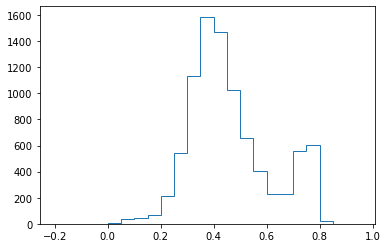

In [11]:
ii = (stellar_phot_df['Mr']>-21) & (stellar_phot_df['Mr']<-19)
_ = pl.hist(stellar_phot_df['Mg'][ii]-stellar_phot_df['Mr'][ii], bins=np.arange(-0.2, 1.0, 0.05), histtype='step')

In [12]:
100*np.mean((stellar_phot_df['Mg'][ii] - stellar_phot_df['Mr'][ii])<0.6)

81.31010295282272

In [13]:
galaxy_class = np.zeros(len(stellar_phot_df))
galaxy_class[(stellar_phot_df['Mg']-stellar_phot_df['Mr'])<0.6] = 0 # Blue Galaxies
galaxy_class[(stellar_phot_df['Mg']-stellar_phot_df['Mr'])>=0.6] = 1 # Red Galaxies

sum(galaxy_class ==0), sum(galaxy_class ==1)

(7187, 1652)

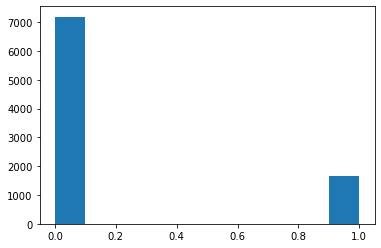

In [14]:
_ = pl.hist(galaxy_class)

In [15]:
stellar_phot_df['GALAXY_CLASS'] = galaxy_class
stellar_phot_df.to_csv('./data/stellar_phot.csv')

In [16]:
# data_scaled =  StandardScaler().fit_transform(stellar_phot_df[::100].drop(['ID'],axis=1))
# np.shape(data_scaled)

In [17]:
# metrics = ['euclidean','cosine','braycurtis']
# n_neighbors = [5,10,15,20]
# min_dists = [0.5,0.1,0.0]

# normal_embeddings = np.zeros((len(n_neighbors), len(min_dist), len(data_scaled), 2))
# precomputed_knn_embeddings = np.zeros((len(n_neighbors), len(min_dist), len(data_scaled), 2))

In [18]:
# for i, nn in enumerate(n_neighbors):
#     for j, dist in enumerate(min_dists):
#         normal_embeddings[i, j] = umap.UMAP(n_neighbors=nn, min_dist=dist).fit_transform(data_scaled)

In [19]:
# mnist_knn = nearest_neighbors(data_scaled,
#                               n_neighbors=250,
#                               metric="euclidean",
#                               metric_kwds=None,
#                               angular=False,
#                               random_state=None,
#                              )

# for i, nn in enumerate(n_neighbors):
#     for j, dist in enumerate(min_dists):
#         precomputed_knn_embeddings[i, j] = umap.UMAP(n_neighbors=nn,
#                                                       min_dist=dist,
#                                                       precomputed_knn=mnist_knn,
#                                                       ).fit_transform(data_scaled)

In [20]:
# f = h5py.File('../data/TNG100-1/Subhalos_Features/morphologies_deeplearn.hdf5','r')
# f.keys()

In [21]:
# morphologies_ids = f['Snapshot_99']['SubhaloID'][:]
# morphologies_ids

In [22]:
# P_Late = f['Snapshot_99']['P_Late'][:]
# P_S0 = f['Snapshot_99']['P_S0'][:]
# P_Sab = f['Snapshot_99']['P_Sab'][:]
# Sigma_Late = f['Snapshot_99']['Sigma_Late'][:]
# Sigma_S0 = f['Snapshot_99']['Sigma_S0'][:]
# Sigma_Sab = f['Snapshot_99']['Sigma_Sab'][:]
# f.close()

In [23]:
# morphologies_df = pd.DataFrame( np.c_[morphologies_ids, P_Late, P_S0, P_Sab, Sigma_Late, Sigma_S0, Sigma_Sab], columns=['ID','P_Late','P_S0','P_Sab','Sigma_Late','Sigma_S0','Sigma_Sab'] )
# morphologies_df = morphologies_df.dropna()
# morphologies_df

In [24]:
# morphologies_df.to_csv('./data/morphologies.csv')

In [25]:
# data_scaled =  StandardScaler().fit_transform(morphologies_df.drop(['ID'],axis=1))
# np.shape(data_scaled)
# metrics = ['euclidean','cosine','braycurtis']
# n_neighbors = [5,10,15,20]
# min_dist = [0.5,0.1,0.0]

# metrics = ['cosine']
# n_neighbors = [5]
# min_dist = [0.5]

# for md in min_dist:
#     for nn in n_neighbors:
#         for me in metrics:
#             model = umap.UMAP(metric=me, n_neighbors=nn, min_dist=md)
#             embedding = model.fit_transform(data_scaled)
#             df = pd.DataFrame( embedding, columns=['X_UMAP','Y_UMAP'] )
#             df.to_csv(f'./data/reduced/UMAP_morpho_nn{nn}_md{md}_{me}.csv')

In [26]:
# stellar_phot_and_morphologies = pd.merge(stellar_phot_df, morphologies_df, on='ID')
# stellar_phot_and_morphologies

In [27]:
# stellar_phot_and_morphologies.to_csv('./data/stellar_phot_and_morphologies.csv')

In [28]:
# data_scaled =  StandardScaler().fit_transform(stellar_phot_and_morphologies.drop(['ID'],axis=1))
# np.shape(data_scaled)
# metrics = ['euclidean','cosine','braycurtis']
# n_neighbors = [5,10,15,20]
# min_dist = [0.5,0.1,0.0]

# metrics = ['cosine']
# n_neighbors = [5]
# min_dist = [0.5]

# for md in min_dist:
#     for nn in n_neighbors:
#         for me in metrics:
#             model = umap.UMAP(metric=me, n_neighbors=nn, min_dist=md)
#             embedding = model.fit_transform(data_scaled)
#             df = pd.DataFrame( embedding, columns=['X_UMAP','Y_UMAP'] )
#             df.to_csv(f'./data/reduced/UMAP_sphotandmorpho_nn{nn}_md{md}_{me}.csv')

In [29]:
# km = KMeans(n_clusters=4, max_iter=500, n_init=30, random_state=1).fit(embedding)
# km.labels_
# pl.scatter(embedding[:,0], embedding[:,1], c=km.labels_)
# pl.colorbar()